## Results for lateralization paper

This notebook contains the results for the lateralization paper. It is organized as follows:
- Section 1: show the original simulated LFPs. Limited cycling?
- Section 2: For $\gamma$ band: spikes count, burst, average amplitude, and power; For $\theta$ band: average amplitude and power. 
- Section 3: The phase information for $\gamma$ band and $\theta$ band (polar graph). The phase locking value between left and right hemispheres; The phase-amplitude coupling for $\gamma$ band and $\theta$ band.
- Section 4: The distribution of structural connections in limbic subnetwork; Homotopic vs Heterotopic connections;
- Section 5: Meta-connectivity.


In [1]:
import sys
sys.path.append('/Users/yilewang/workspaces/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from os.path import join as pjoin
from scipy import signal
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from tvbtools.tools import burst_detection
from statannotations.Annotator import Annotator
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from tvbtools.tools.statools import bootstrap_test
import io

In [3]:
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R',
              'pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L',
              'PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R',
              'mTEMp-L','mTEMp-R']
node_one = ['aCNG', 'mCNG', 'pCNG', 'HIP', 'PHG', 'AMY', 'sTEMp', 'mTEMp']
group4 = ["SNC", "NC", "MCI", "AD"]
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]


# conduct signal downsample first
def down_sample(data, fs, new_fs):
    new_data = signal.decimate(data, int(fs/new_fs), axis=0, zero_phase=True)
    return new_data

# generate a sos bandpass filter function
def butter_bandpass(lowcut, highcut, fs, data, order=5):
    nyq = 0.5 * fs # nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], analog=False, btype="band", output="sos")
    filtered_signal = signal.sosfiltfilt(sos, data)
    return filtered_signal


def before_after_graph(befores, afters, ax, ylim=[-0.5, 35]):
    # plotting the points
    ax.scatter(np.zeros(len(befores)), befores, s=1, color='k')
    ax.scatter(np.ones(len(afters)), afters, s=1, color='k')
    # plotting the lines
    for i in range(len(befores)):
        ax.plot( [0,1], [befores[i], afters[i]], alpha=0.2, color='k')
    # hide the frame
    sns.despine(top=True, right=True, left=True)
    # ax.set_xticks([0.25, 0.75], ['gc', 'gc_K21'])
    ax.set_xticks([])
    # find max of befores and afters
    ax.set_ylim(ylim)

def spikes_bursts(signal, fs, caseid, group):
    subj_df = pd.DataFrame()
    # get spikes data
    spikes_table = burst_detection.generate_spikes_analyses(signal[8192:], fs, thresh_prominence=0.5)

    ### AVERAGE SPIKE FEATURES
    # get the average spike amplitude
    avg_spike_amplitude = np.mean(spikes_table['spike_amplitude'])

    # get the average spike frequency
    avg_spike_frequency = np.mean(spikes_table['inst_freq'][1:])
    
    # get the average spike width
    avg_spike_width_xi = np.mean(spikes_table['width'])

    # get the average isi_s
    avg_isi_s = np.mean(spikes_table['isi_s'])


    # get burst features
    burst_table_xi = burst_detection.bursts_detection(spikes_table)
    # burst analyses
    burst_xi_stats = burst_detection.generate_bursts_stats(caseid, burst_table_xi, spikes_table)

    burst_xi_stats['group'] = group

    burst_xi_stats['Mean Spike Amplitude'] = avg_spike_amplitude
    burst_xi_stats['Mean Spike Frequency'] = avg_spike_frequency
    # burst_xi_stats['Mean Spike Width'] = avg_spike_width_xi
    burst_xi_stats['Mean ISI (sec)'] = avg_isi_s
    burst_xi_stats['Number of spikes'] = len(spikes_table.spike)
    subj_df = pd.concat([subj_df, burst_xi_stats])
    # replace all nan to 0
    subj_df.fillna(0, inplace=True)
    return subj_df

def get_bursts_amplitude(filtered, fs, thresh_min = -2, thresh_prominence = 0.2):
    filtered_peaks_signal = filtered
    # Set parameters for the Find peaks function (set to None if not needed)
    thresh_min = thresh_min                     # Min threshold to detect spikes
    thresh_prominence = thresh_prominence              # Min spike amplitude  
    thresh_min_width = 0.5 * (fs/1000)   # Min required width in ms
    distance_min = 1 * (fs/1000) 
    filtered_peaks, filtered_peaks_dict = find_peaks(filtered_peaks_signal,
        height=thresh_min,
        threshold=thresh_min,
        distance=distance_min,
        prominence=0.2,
        width=thresh_min_width,
        wlen=None,       # Window length to calculate prominence
        rel_height=0.5,  # Relative height at which the peak width is measured
        plateau_size=None)

    burst_amplitude = filtered_peaks_dict['prominences']  # prominence parameter is needed
    return burst_amplitude
        

### Section 0: loading data

In [4]:
# Load the data
data_path = '/Users/yilewang/Documents/simulated_LFP_Gc_2modes'
# Load the info
table_path = '/Users/yilewang/workspaces/data4project/mega_table.xlsx'
# stored data path
new_asymmetry = '/Users/yilewang/workspaces/data4project/new_asymmetry'

table = pd.read_excel(table_path, sheet_name='hodgepodge', skiprows=1)
groups = table.group[:74]
caseids = table.caseid[:74]
Gc = table.Gc[:74]

### Section 1: Original LFPs

In [5]:
# filter the data
fs = 81920
subj_df_xi = pd.DataFrame()
subj_df_alpha = pd.DataFrame()
for caseid, group, gc in zip(caseids, groups, Gc):
    # Load the data
    data = np.load(pjoin(data_path, str(group), f'{caseid}_{gc}.npy'))
    xi = np.mean(data[:,0,:,:], axis=2)
    alpha = np.mean(data[:,1,:,:], axis=2)
    
    # figure = plt.figure(figsize=(10, 5))
    # ax1 = figure.add_subplot(121)
    # ax2 = figure.add_subplot(122)
    # ax1.plot(xi[:81920, :],alpha=0.5)
    # ax2.plot(alpha[:81920, :],alpha=0.5)
    # plt.title(f'{group} {caseid} {gc}')
    # plt.show()

    # apply the bandpass filter
    # pCNG_L_xi_filtered = butter_bandpass(3, 10, fs, xi[:,4])
    # pCNG_L_alpha_filtered = butter_bandpass(3, 10, fs, alpha[:,4])
    
    for i in range(len(node_names)):
        xi_filtered = butter_bandpass(3, 10, fs, xi[:,i])
        xi_node = spikes_bursts(xi[:,i], fs=fs, caseid=caseid, group=group)
        xi_node['node'] = node_names[i]
        # alpha_node = spikes_bursts(alpha[:,i], fs, caseid, group)
        # alpha_node['node'] = node_names[i]
        subj_df_xi = pd.concat([subj_df_xi, xi_node])
        # subj_df_alpha = pd.concat([subj_df_alpha, alpha_node])


    # apply spike_burst function
    # Plot the LFP
    # plt.figure(figsize=(10, 5))
    # plt.plot(xi[:81920,4],label='xi_left')    
    # plt.plot(alpha[:81920,4],label='alpha_left')
    # # plt.plot(xi[:,5],label='xi_right')
    # # plt.plot(alpha[:,5],label='alpha_right')
    # plt.legend()
    # plt.title(f'{caseid} {gc}')
    # plt.show()

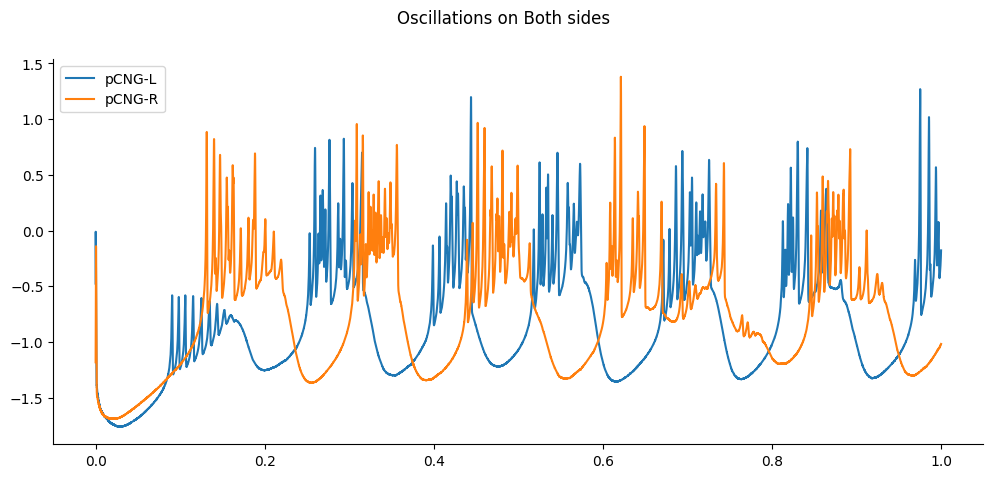

In [6]:
# %matplotlib widget
# load npy data
new_case = np.load('/Users/yilewang/Documents/local_inhibition_only_gc/SNC/8709A_0.009.npy')
new_case_mean = np.mean(new_case, axis=3)
# plot 3d plot

figure = plt.figure(figsize=(12, 5))
plt.suptitle('Oscillations on Both sides')
# ax1 = figure.add_subplot(121, projection='3d')
# for node in [4,5]:
#     ax1.plot3D(new_case_mean[:81920,0,node], new_case_mean[:81920, 1, node], new_case_mean[:81920,2,node], label = node_names[node])
# ax1.set_xlabel('x')
# ax1.set_ylabel('y')
# ax1.set_zlabel('z')

ax2 = figure.add_subplot(111)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
for node in [4,5]:
    ax2.plot(np.arange(0,1,1/81920) ,new_case_mean[:81920,0,node], label = node_names[node])
ax2.legend()
plt.show()    


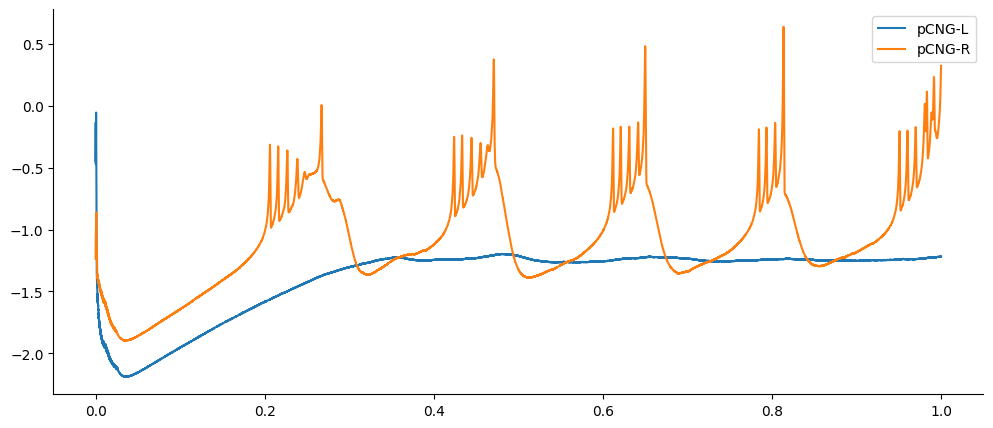

In [7]:
# %matplotlib widget
# load npy data
new_case = np.load('/Users/yilewang/Documents/local_inhibition_only_gc/AD/1477A_0.02.npy')
new_case_mean = np.mean(new_case, axis=3)
# plot 3d plot

figure = plt.figure(figsize=(12, 5))
# plt.suptitle('Oscillation on One side')
# ax1 = figure.add_subplot(121, projection='3d')
# for node in [4,5]:
#     ax1.plot3D(new_case_mean[:81920,0,node], new_case_mean[:81920, 1, node], new_case_mean[:81920,2,node], label = node_names[node])
# ax1.set_xlabel('x')
# ax1.set_ylabel('y')
# ax1.set_zlabel('z')

ax2 = figure.add_subplot(111)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
for node in [4,5]:
    ax2.plot( np.arange(0,1,1/81920) ,new_case_mean[:81920,0,node], label = node_names[node])
ax2.legend()
plt.show() 

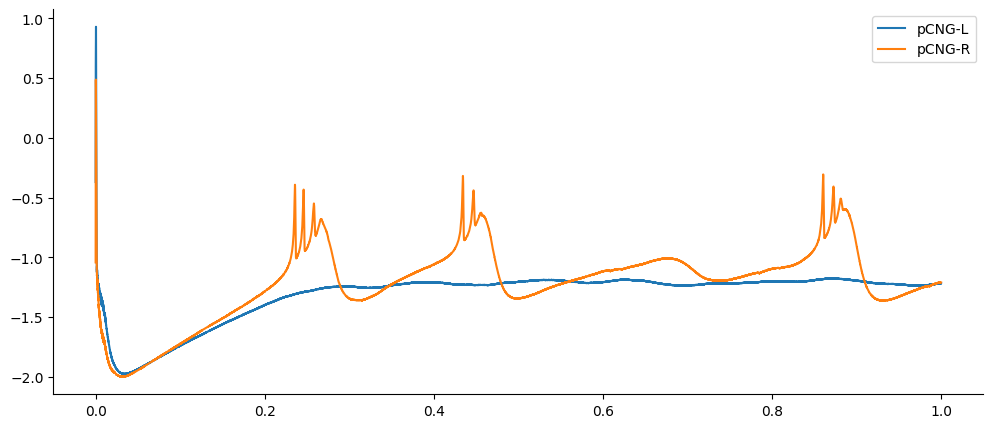

In [8]:
# %matplotlib widget
# load npy data
new_case = np.load('/Users/yilewang/Documents/local_inhibition_only_gc/MCI/2391A_0.024.npy')
new_case_mean = np.mean(new_case, axis=3)
# plot 3d plot

figure = plt.figure(figsize=(12, 5))

# remove top and right frame
# plt.suptitle('Weak Oscillations on Both sides')
# ax1 = figure.add_subplot(121, projection='3d')
# for node in [4,5]:
#     ax1.plot3D(new_case_mean[:81920,0,node], new_case_mean[:81920, 1, node], new_case_mean[:81920,2,node], label = node_names[node])
# ax1.set_xlabel('x')
# ax1.set_ylabel('y')
# ax1.set_zlabel('z')

ax2 = figure.add_subplot(111)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
for node in [4,5]:
    ax2.plot(np.arange(0,1,1/81920) ,new_case_mean[:81920,0,node], label = node_names[node])
ax2.legend()
plt.show()    

In [9]:
# cols = list(subj_df_xi.columns)
# cols = [cols[5]] + cols[0:5] + cols[6:]
# subj_df_xi = subj_df_xi[cols]
# subj_df_alpha = subj_df_alpha[cols]

In [10]:
# export subj_df_xi and subj_df_alpha
# subj_df_xi.to_csv(pjoin(new_asymmetry, 'asymmetry_xi_analyses_new.csv'), index=False)
# subj_df_alpha.to_csv(pjoin(new_asymmetry, 'asymmetry_alpha_analyses_new.csv'), index=False)

#### Section 1.1: LFPs, pCNG-L vs pCNG-R

In [ ]:
df_data = 

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_pCNG-L vs. NC_pCNG-R: Mann-Whitney-Wilcoxon test two-sided, P_val:2.378e-04 U_stat=3.000e+01
SNC_pCNG-L vs. SNC_pCNG-R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.082e-03 U_stat=1.500e+01
MCI_pCNG-L vs. MCI_pCNG-R: Mann-Whitney-Wilcoxon test two-sided, P_val:1.164e-07 U_stat=1.620e+02
AD_pCNG-L vs. AD_pCNG-R: Mann-Whitney-Wilcoxon test two-sided, P_val:8.681e-03 U_stat=3.300e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_pCNG-L vs. NC_pCNG-R: Mann-Whitney-Wilcoxon test two-sided, P_val:5.630e-04 U_stat=3.600e+01
SNC_pCNG-L vs. SNC_pCNG-R: Mann-Whitney-Wilcoxon test two-sided, P_val:1.130e-02 U_stat=1.600e+01
MCI_pCNG-L vs. MCI_pCNG-R: Mann-Wh

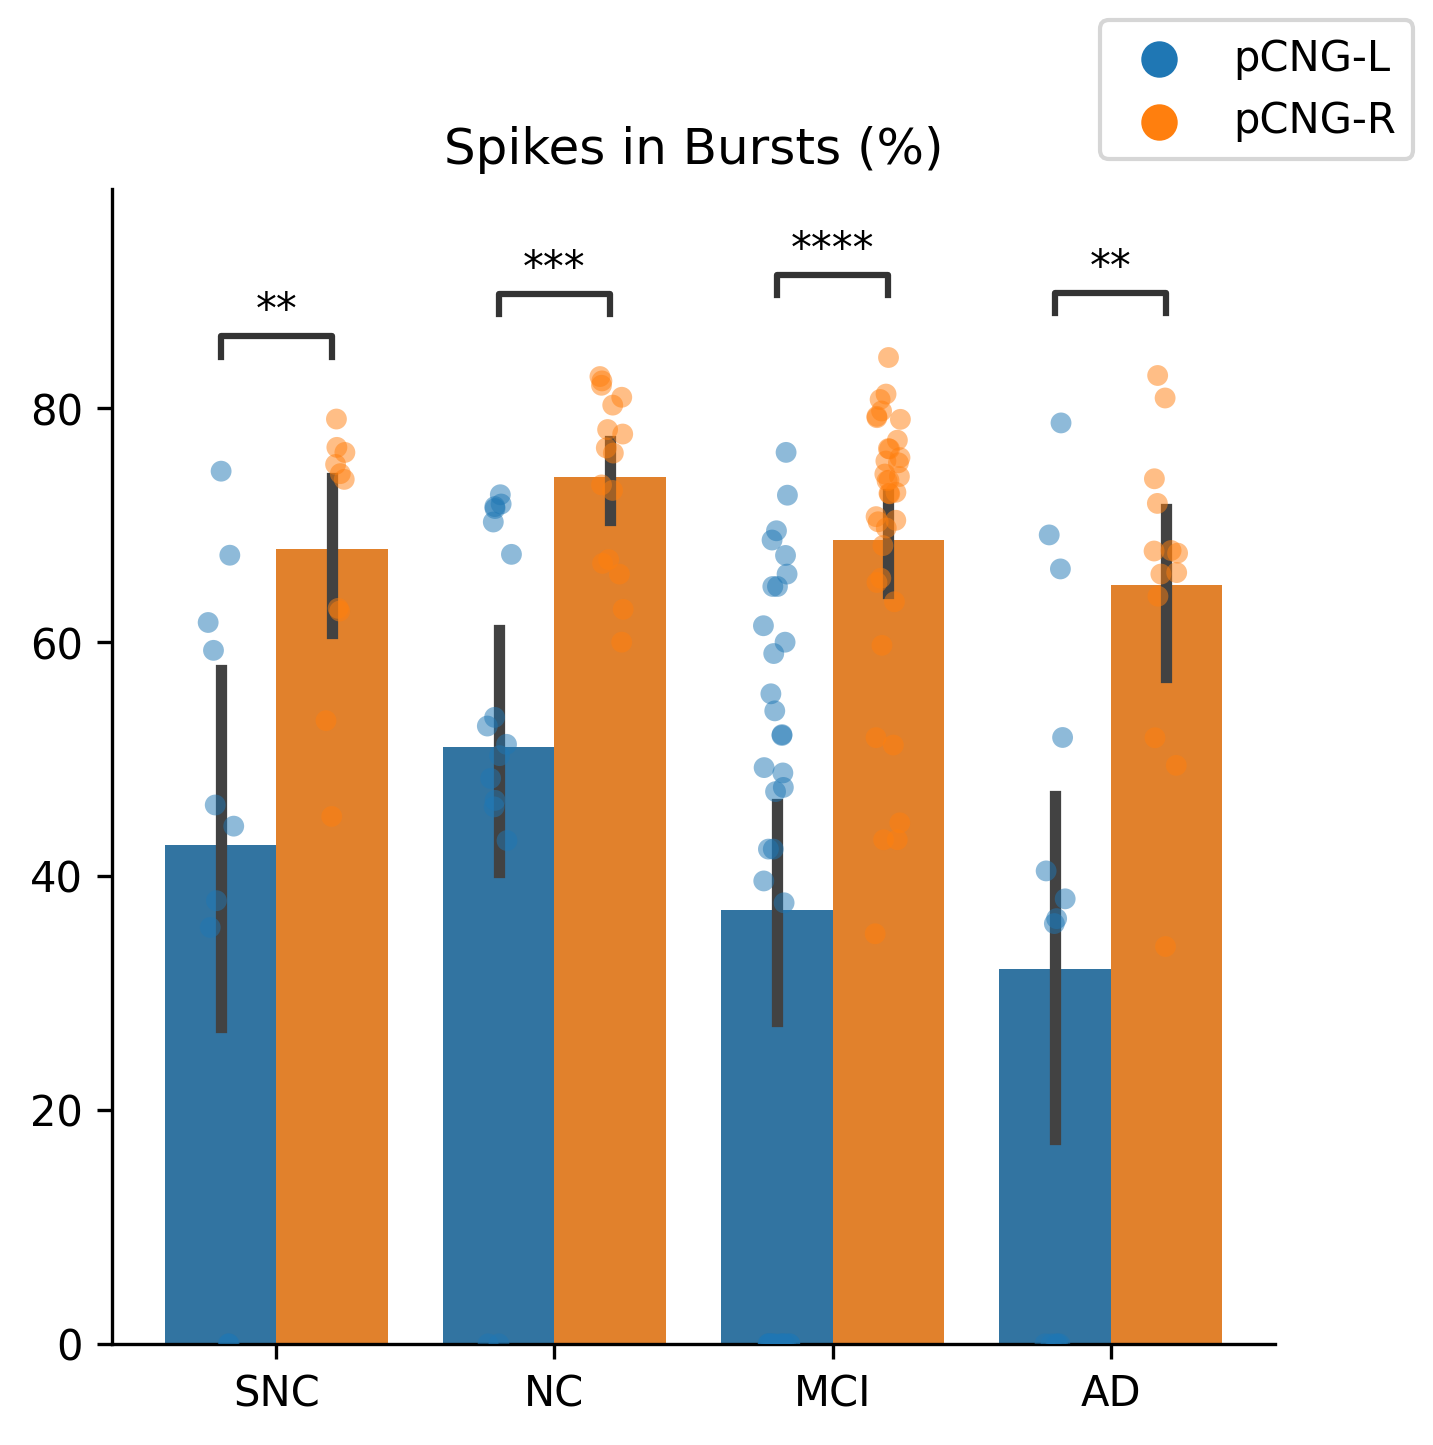

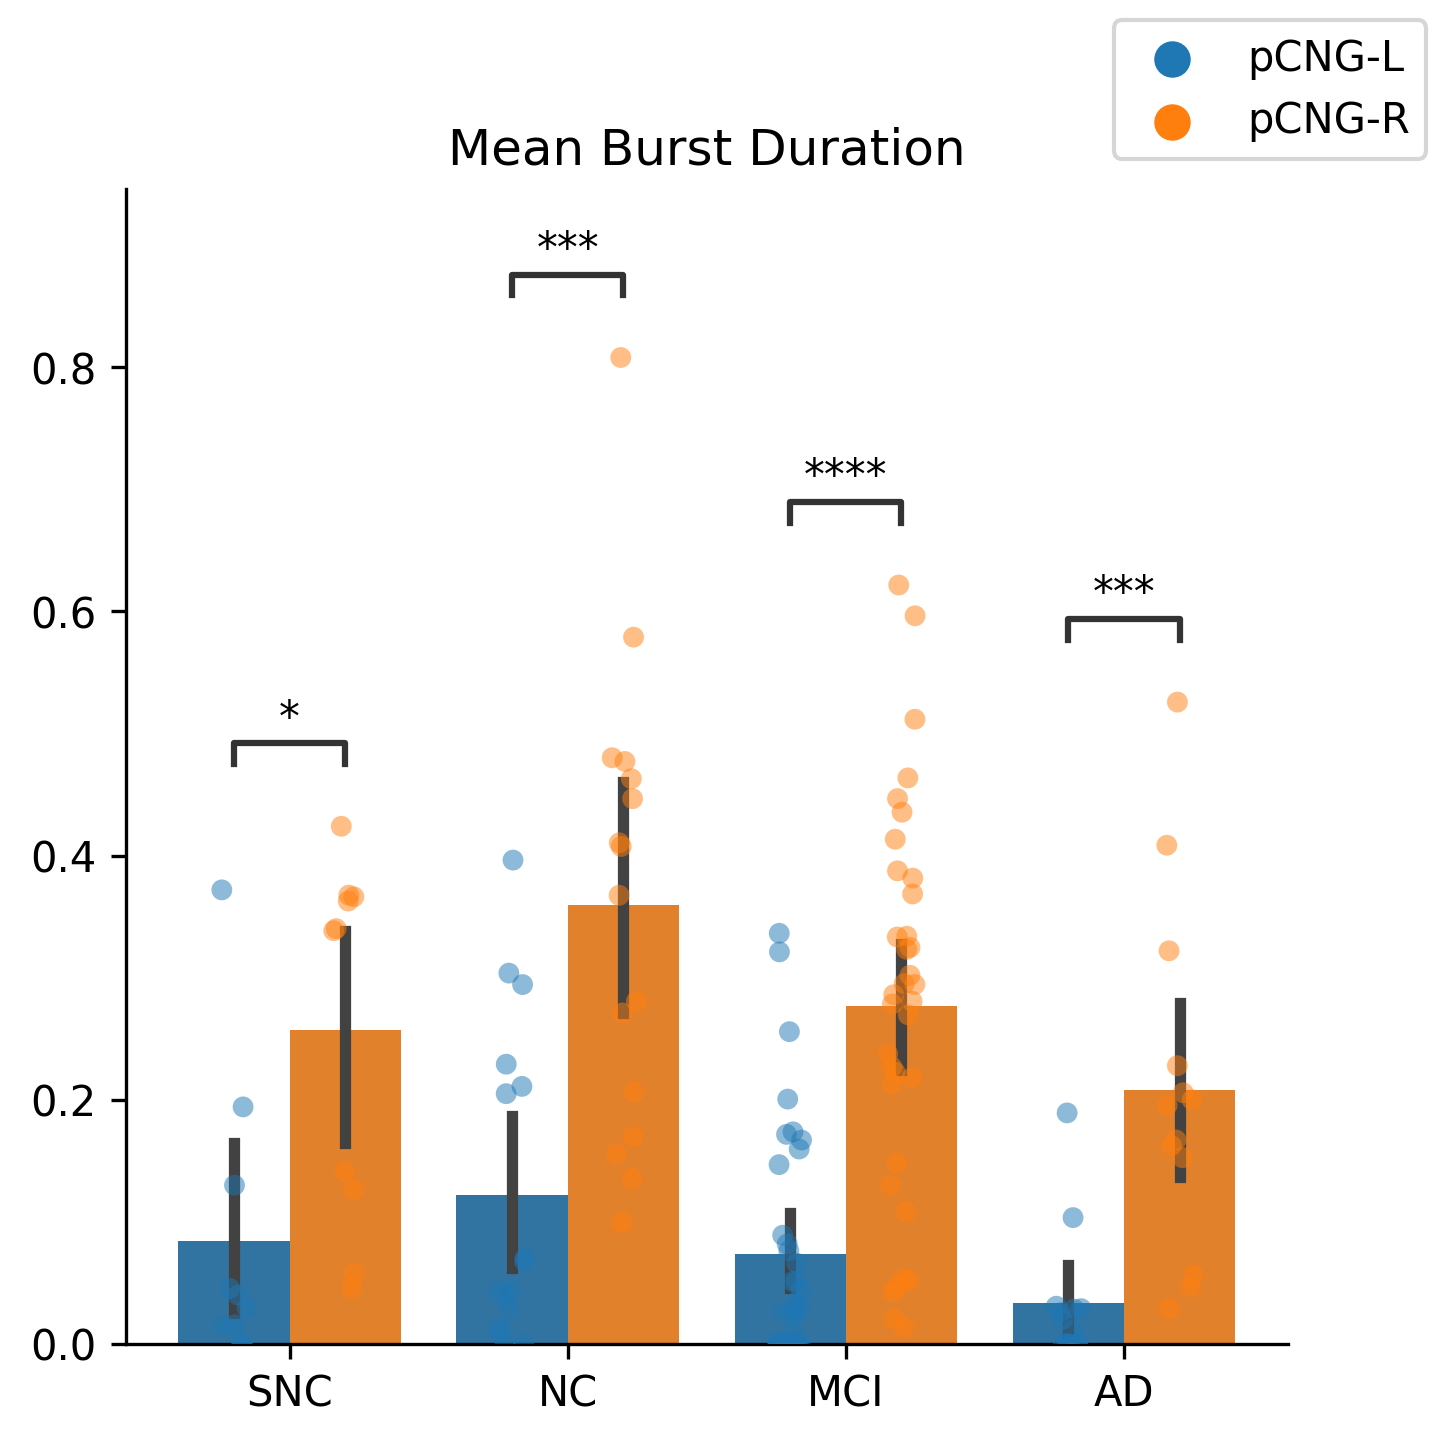

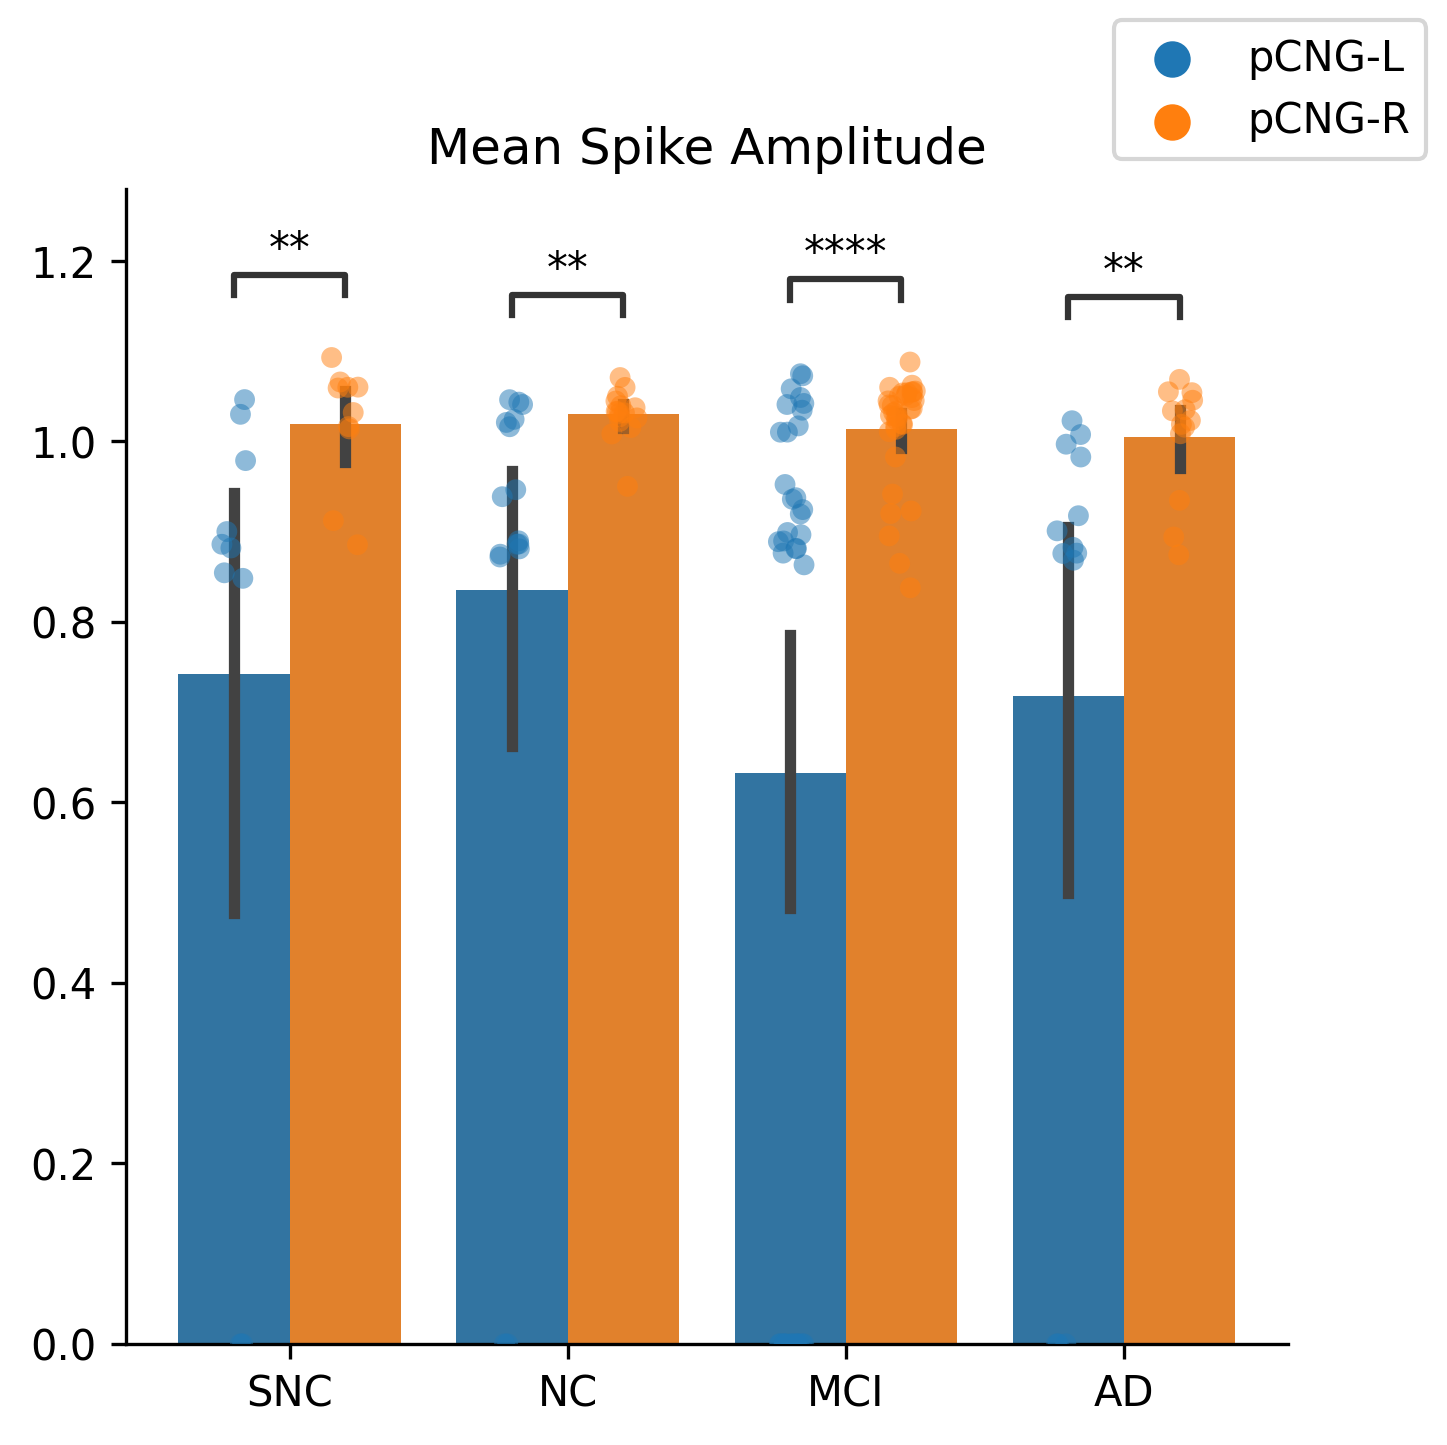

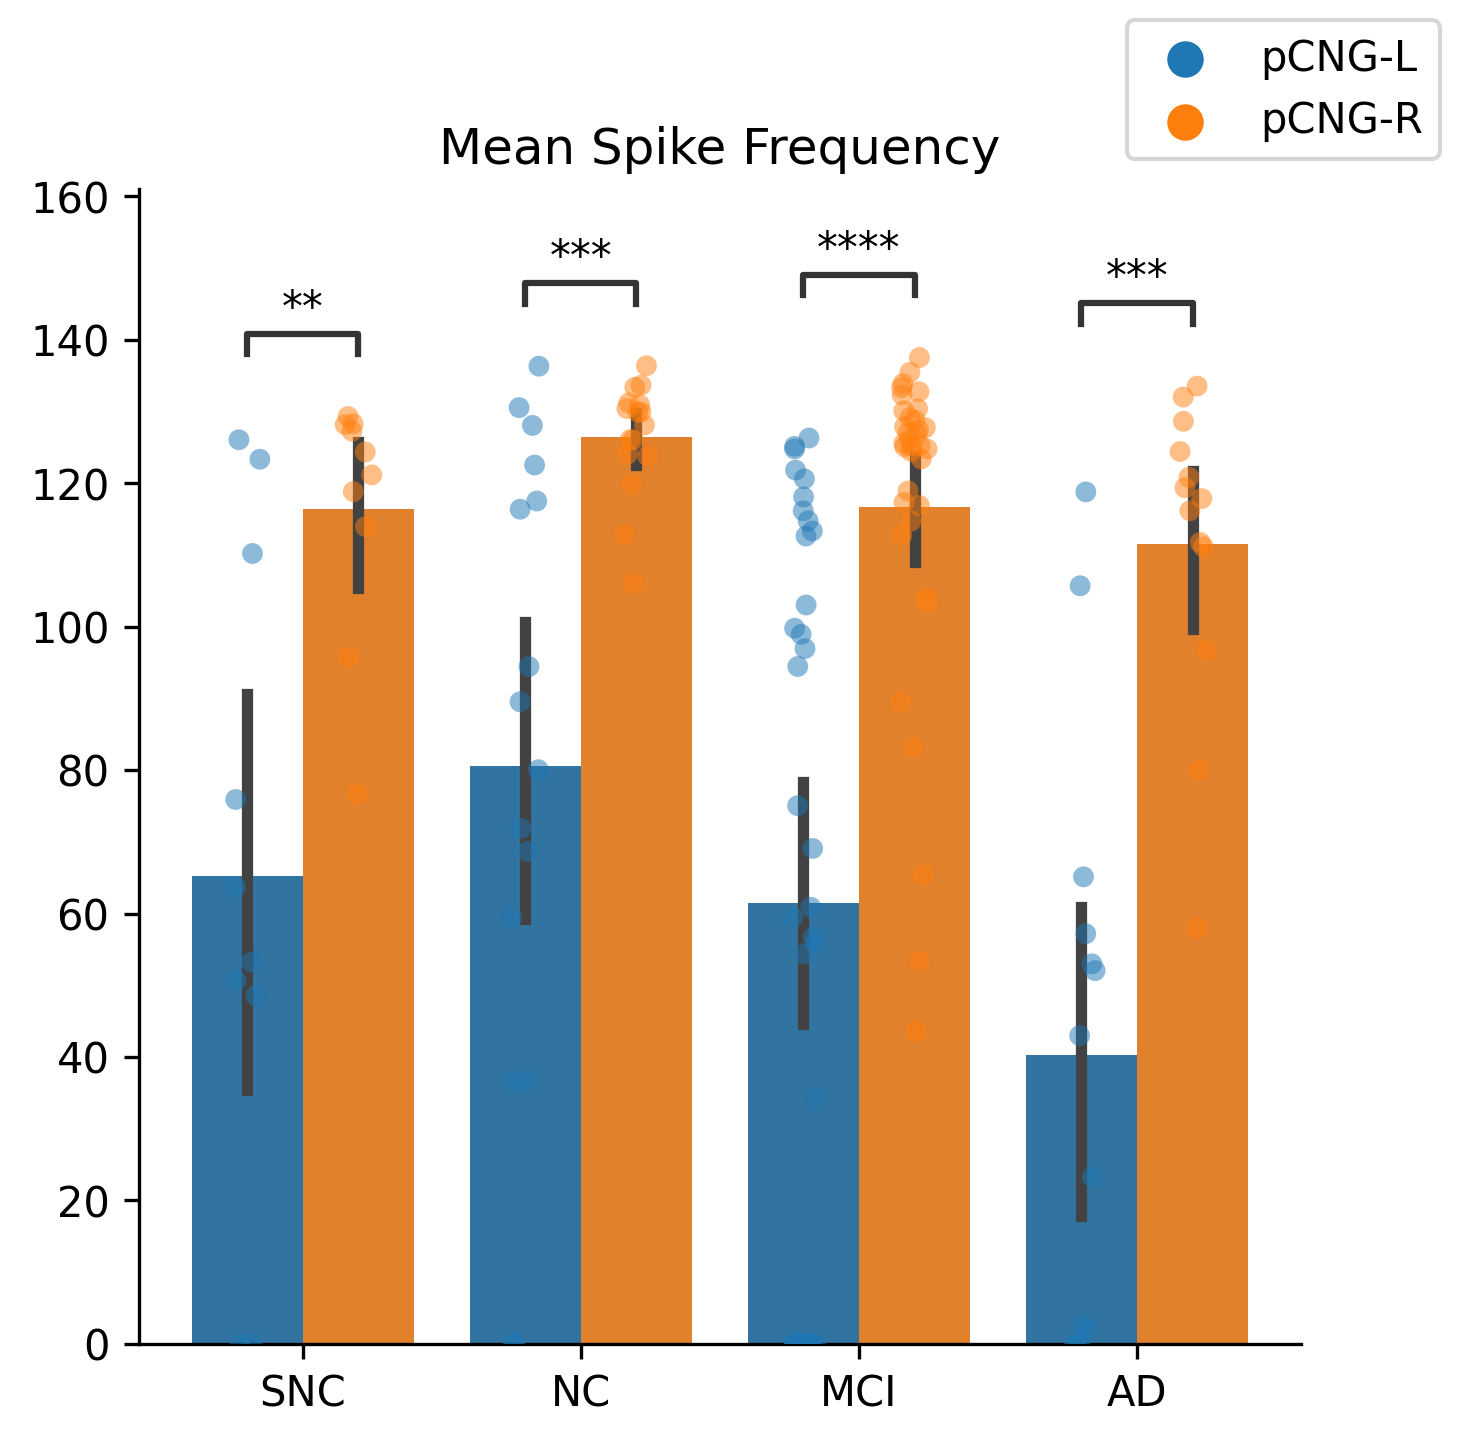

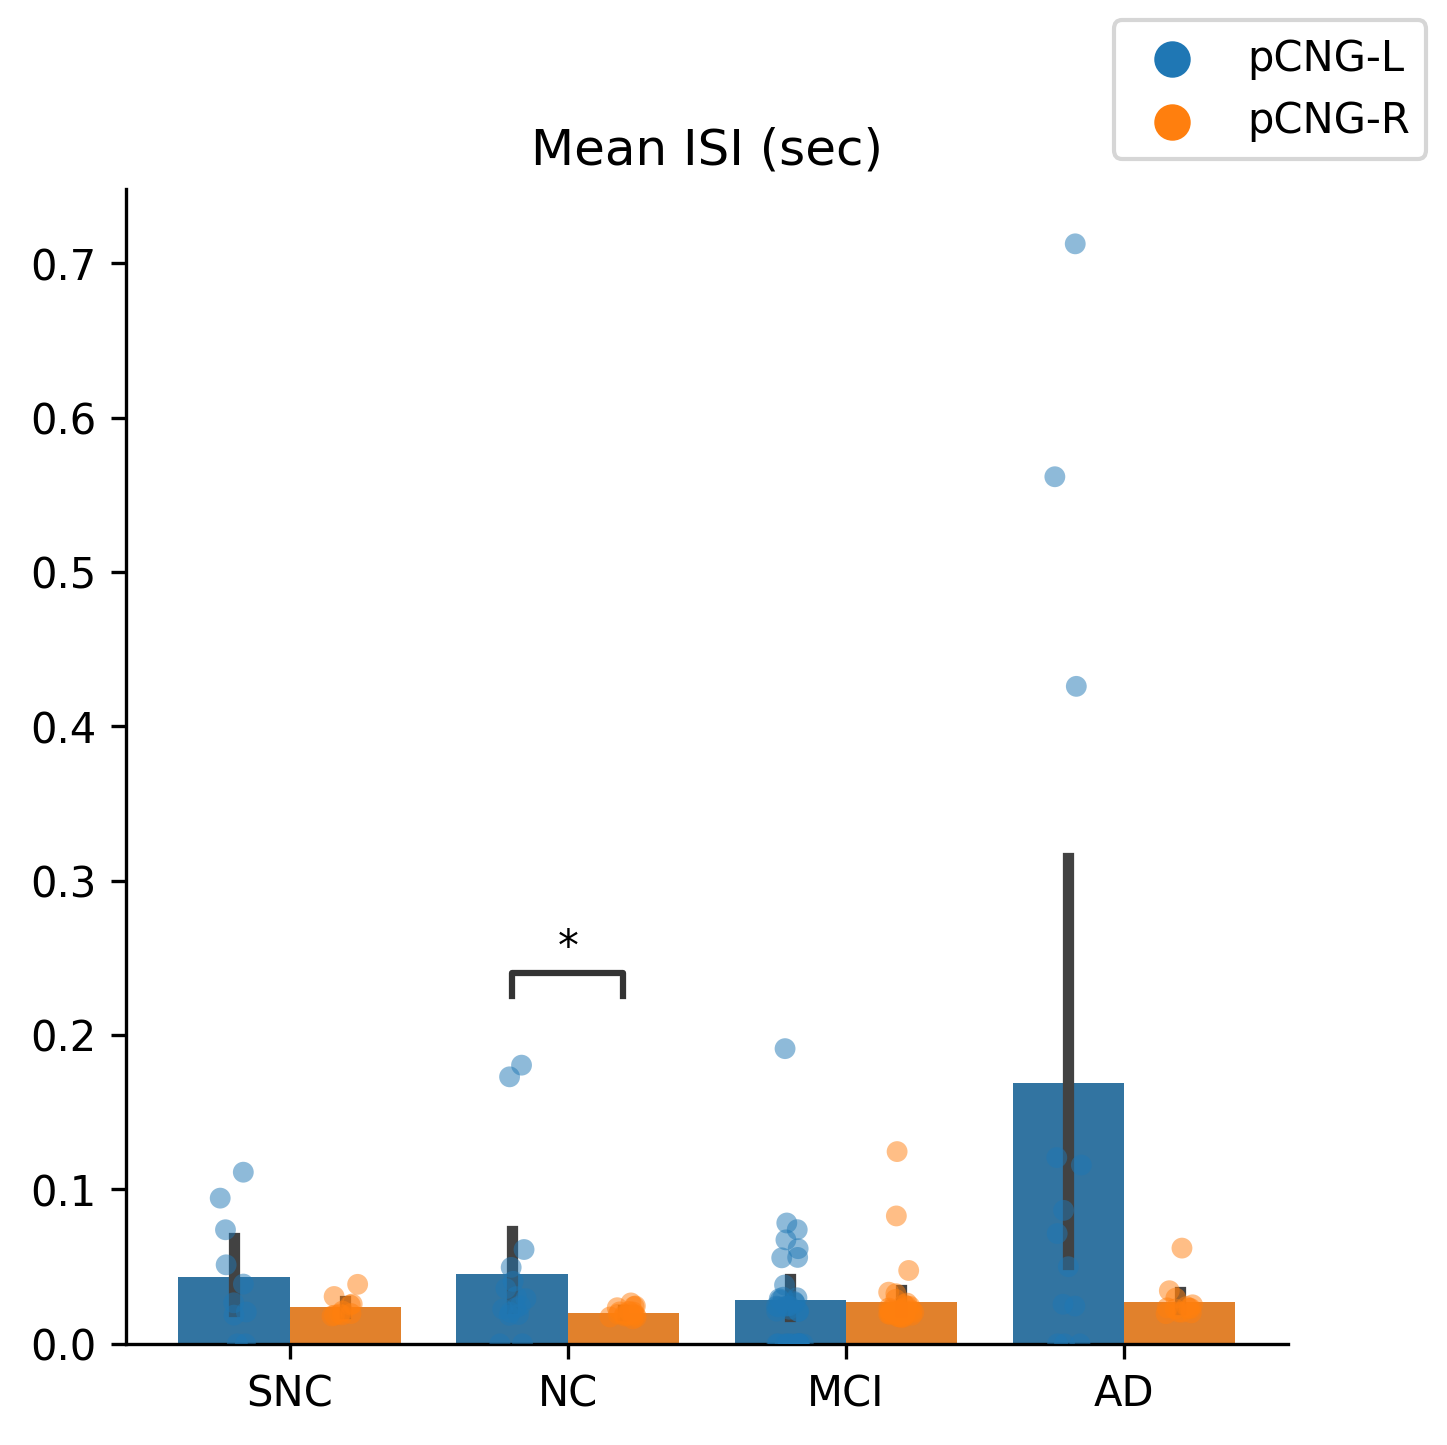

In [29]:
# calculate the differences between xi and alpha in all columns
for i in subj_df_xi.columns[2:14]:
    if subj_df_xi[i].dtype == 'float64':
    #     ax = figure.add_subplot(4,4, list(subj_df_alpha.columns[2:13]).index(i)+1)
        figure = plt.figure(figsize=(5, 5), dpi=300)
        # ax = figure.add_subplot(2,6, list(subj_df_alpha.columns[2:13]).index(i)+1)
        ax = figure.add_subplot(1,1,1)
        sns.barplot(x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]['group'], 
                    y=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])][i], 
                    hue=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]["node"],
                    ax=ax)
        sns.stripplot(x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]['group'], 
                    y=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])][i], 
                    hue=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]["node"],
                    ax=ax, dodge=True, alpha=0.5, jitter=True)
        # no legend
        ax.get_legend().remove()
        # hide top and right frame
        sns.despine(top=True, right=True)
        # sns.barplot(x='group', y=i, data=subj_df_alpha, ax=ax)
        ax.set_title(i)
        # hide ax xlabel
        ax.set_xlabel('')
        ax.set_ylabel('')
        handles, labels = figure.gca().get_legend_handles_labels()
        figure.legend(handles[:2], labels[:2], loc='upper right')
        annot = Annotator(ax, [
                (("SNC", "pCNG-L"), ("SNC", "pCNG-R")),(("NC", "pCNG-L"), ("NC", "pCNG-R")), (("MCI","pCNG-L"), ("MCI", "pCNG-R")), (("AD", "pCNG-L"), ("AD", "pCNG-R"))],
                x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]['group'],
                y=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])][i],
                hue=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', 'pCNG-R'])]["node"])
        annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True)
        annot.apply_and_annotate()

#### Section 1.2: LFPs, pCNG-R - pCNG-L

In [1]:

# # plot the comparison between xi and alpha
fig, ax = plt.subplots(figsize=(20, 10))

# calculate the differences between xi and alpha in all columns
subj_xi_diff = pd.DataFrame()
subj_xi_diff['group'] = groups
subj_xi_diff['caseid'] = caseids
for i in subj_df_xi.columns[2:13]:


    yvar = np.abs(subj_df_xi[subj_df_xi['node'].isin(['pCNG-R'])][i] - subj_df_xi[subj_df_xi['node'].isin(['pCNG-L'])][i])/(subj_df_xi[subj_df_xi['node'].isin(['pCNG-R'])][i] + subj_df_xi[subj_df_xi['node'].isin(['pCNG-L'])][i])
    # yvar = np.abs(subj_df_xi[subj_df_xi['node'].isin(['pCNG-R'])][i] - subj_df_xi[subj_df_xi['node'].isin(['pCNG-L'])][i])
    subj_xi_diff[i] = yvar.to_numpy()

    sns.barplot(x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L', ])]['group'], 
                y= yvar,
                 ax=ax, palette=colors)
    sns.stripplot(x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L'])]['group'], 
                y=yvar, 
                 ax=ax, dodge=True, alpha=0.25, jitter=True, color='k')

    # hide top and right frame
    sns.despine(top=True, right=True)
    # sns.barplot(x='group', y=i, data=subj_df_alpha, ax=ax)
    ax.set_title(i)
    # hide ax xlabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    handles, labels = figure.gca().get_legend_handles_labels()
    figure.legend(handles[:2], labels[:2], loc='upper right')
    
    annot = Annotator(ax, [
            (("SNC"), ("NC")),(("SNC"), ("MCI")),(("SNC"), ("AD")), (("NC"), ("MCI")), (("MCI"),("AD"))],
            x=subj_df_xi[subj_df_xi['node'].isin(['pCNG-L'])]['group'],
            y=yvar)
    annot.configure(test='Mann-Whitney', text_format='star', comparisons_correction= "BH", hide_non_significant=True, correction_format="replace")
    annot.apply_and_annotate()
plt.show()
# subj_xi_diff.to_csv(pjoin(new_asymmetry, asymmetry_xi_diff.csv), index=False)

NameError: name 'plt' is not defined

### Section 1.3 bootstrap test

In [13]:
figure = plt.figure(figsize=(15, 7), dpi=300)
for i in subj_df_alpha.columns[2:13]:
    ax = figure.add_subplot(2,6, list(subj_df_alpha.columns[2:13]).index(i)+1)
    ax.set_title(i)
    yvar = np.array(np.abs(subj_df_xi[subj_df_xi['node'].isin(['pCNG-R'])][i] - subj_df_xi[subj_df_xi['node'].isin(['pCNG-L'])][i])/(subj_df_xi[subj_df_xi['node'].isin(['pCNG-R'])][i] + subj_df_xi[subj_df_xi['node'].isin(['pCNG-L'])][i]))
    _yvar = pd.Series(yvar)
    ddf = pd.DataFrame()
    ddf = pd.concat([ddf, groups, _yvar], axis=1)
    ddf.columns = ["group", "value"]
    for j in range(4):
        ci, box = bootstrap_test(ddf["value"][ddf.group == group4[j]].to_numpy(), iteration=1000, visual=False)
        sns.kdeplot(x = box, linewidth=2, fill = colors[j], color=colors[j])
        ax.set(ylim=(-2.2, 7))
        # hide top and right frame
        sns.despine(top=True, right=True)
        ax.hlines(y=-0.3-0.5*j, xmin=ci[0], xmax=ci[1], linewidth=2, color = colors[j])
        ax.vlines(x=ci[0], ymin=-0.3-0.5*j-0.2, ymax=-0.3-0.5*j+0.2, linewidth=2, color = colors[j])
        ax.vlines(x=ci[1], ymin=-0.3-0.5*j-0.2, ymax=-0.3-0.5*j+0.2, linewidth=2, color = colors[j])
    ax.set_ylabel('')

<Figure size 4500x2100 with 0 Axes>

### Section 2.0 Structural Connectivity

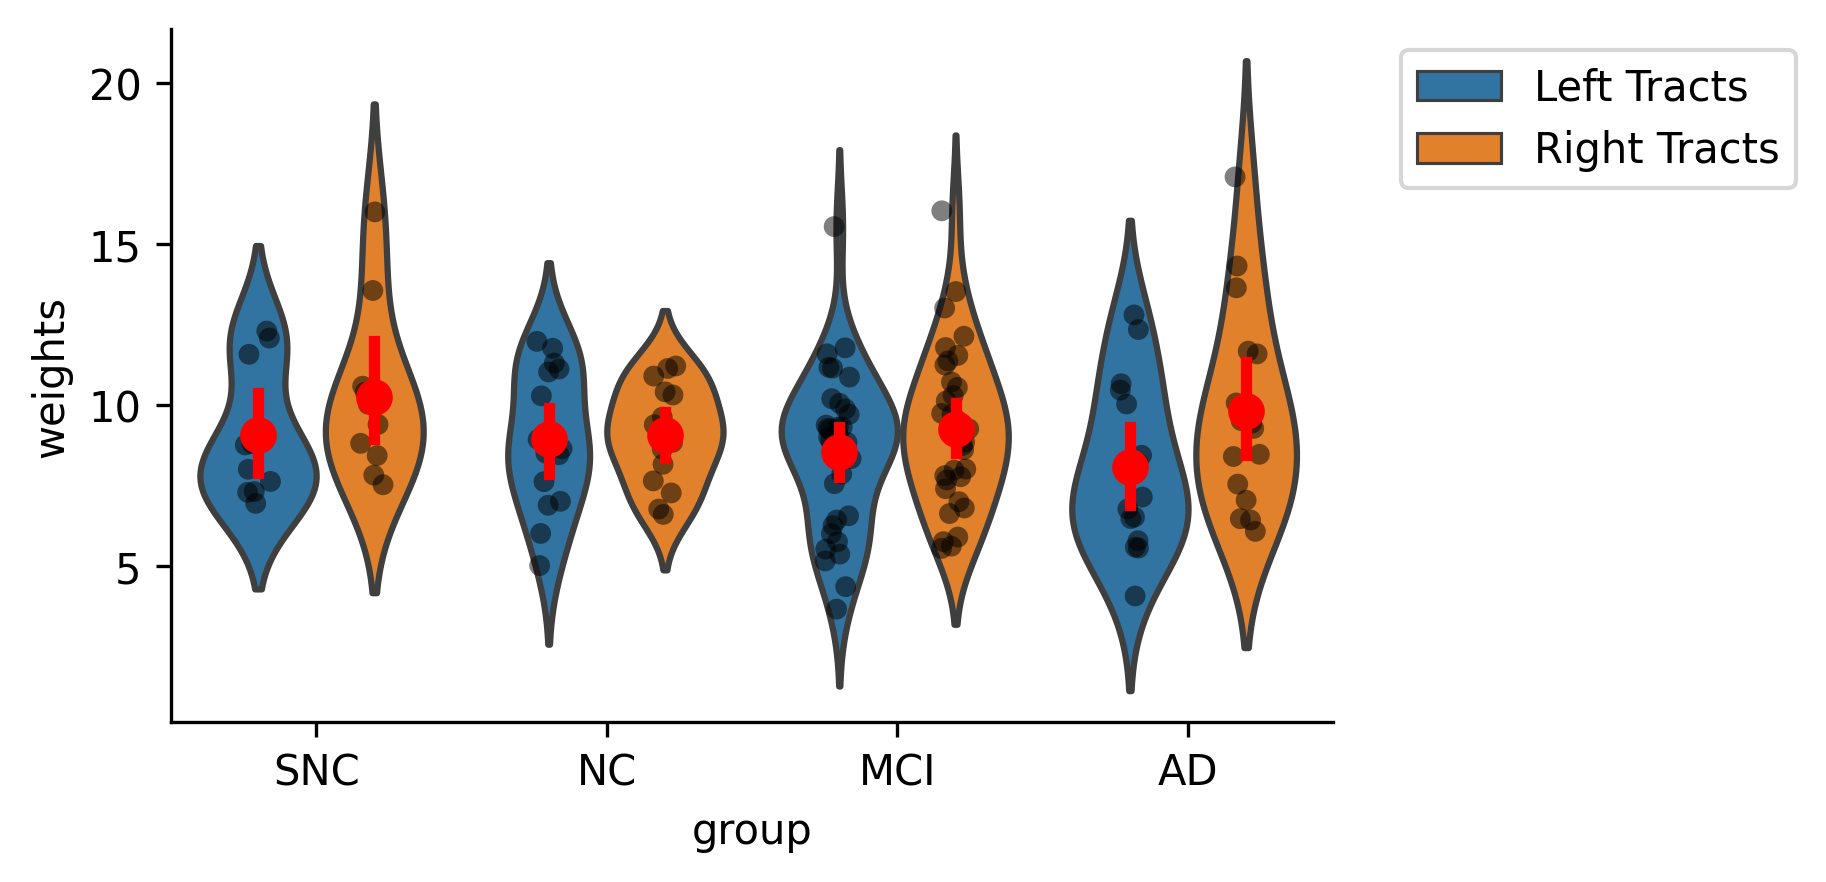

In [14]:
# load the data
sc_data = pd.read_csv(pjoin(new_asymmetry, 'asymmetry_sc.csv'))
# plot the distribution
figure = plt.figure(figsize=(5, 3),dpi=300)

ax1 = figure.add_subplot(111)

sns.violinplot(x='group', y='values', data=sc_data, hue="labels", ax=ax1, inner=None,zorder=0)
sns.stripplot(x='group', y = 'values', data= sc_data, hue="labels", dodge=0.5, palette=['black'], ax=ax1, jitter=True,  alpha=0.5, zorder=1)
sns.pointplot(x = 'group' , y='values', data=sc_data, estimator=np.mean, hue="labels", palette=["red"],ax=ax1, dodge=0.4, errorbar = None, join=True, linestyles="", zorder=10)
# hide top and right frame
sns.despine(top=True, right=True)
ax1.set_ylabel('weights')
ax1.legend([],[], frameon=False)
# only keep violinplot legend
handles, labels = figure.gca().get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2],bbox_to_anchor=(1.04, 1), loc="upper left")



#### Section 2.1: Homotopic vs Heterotopic connections

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SNC_Homotopic vs. MCI_Homotopic: Mann-Whitney-Wilcoxon test two-sided, P_val:3.928e-02 U_stat=2.510e+02
SNC_Homotopic vs. AD_Homotopic: Mann-Whitney-Wilcoxon test two-sided, P_val:1.426e-02 U_stat=1.270e+02


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


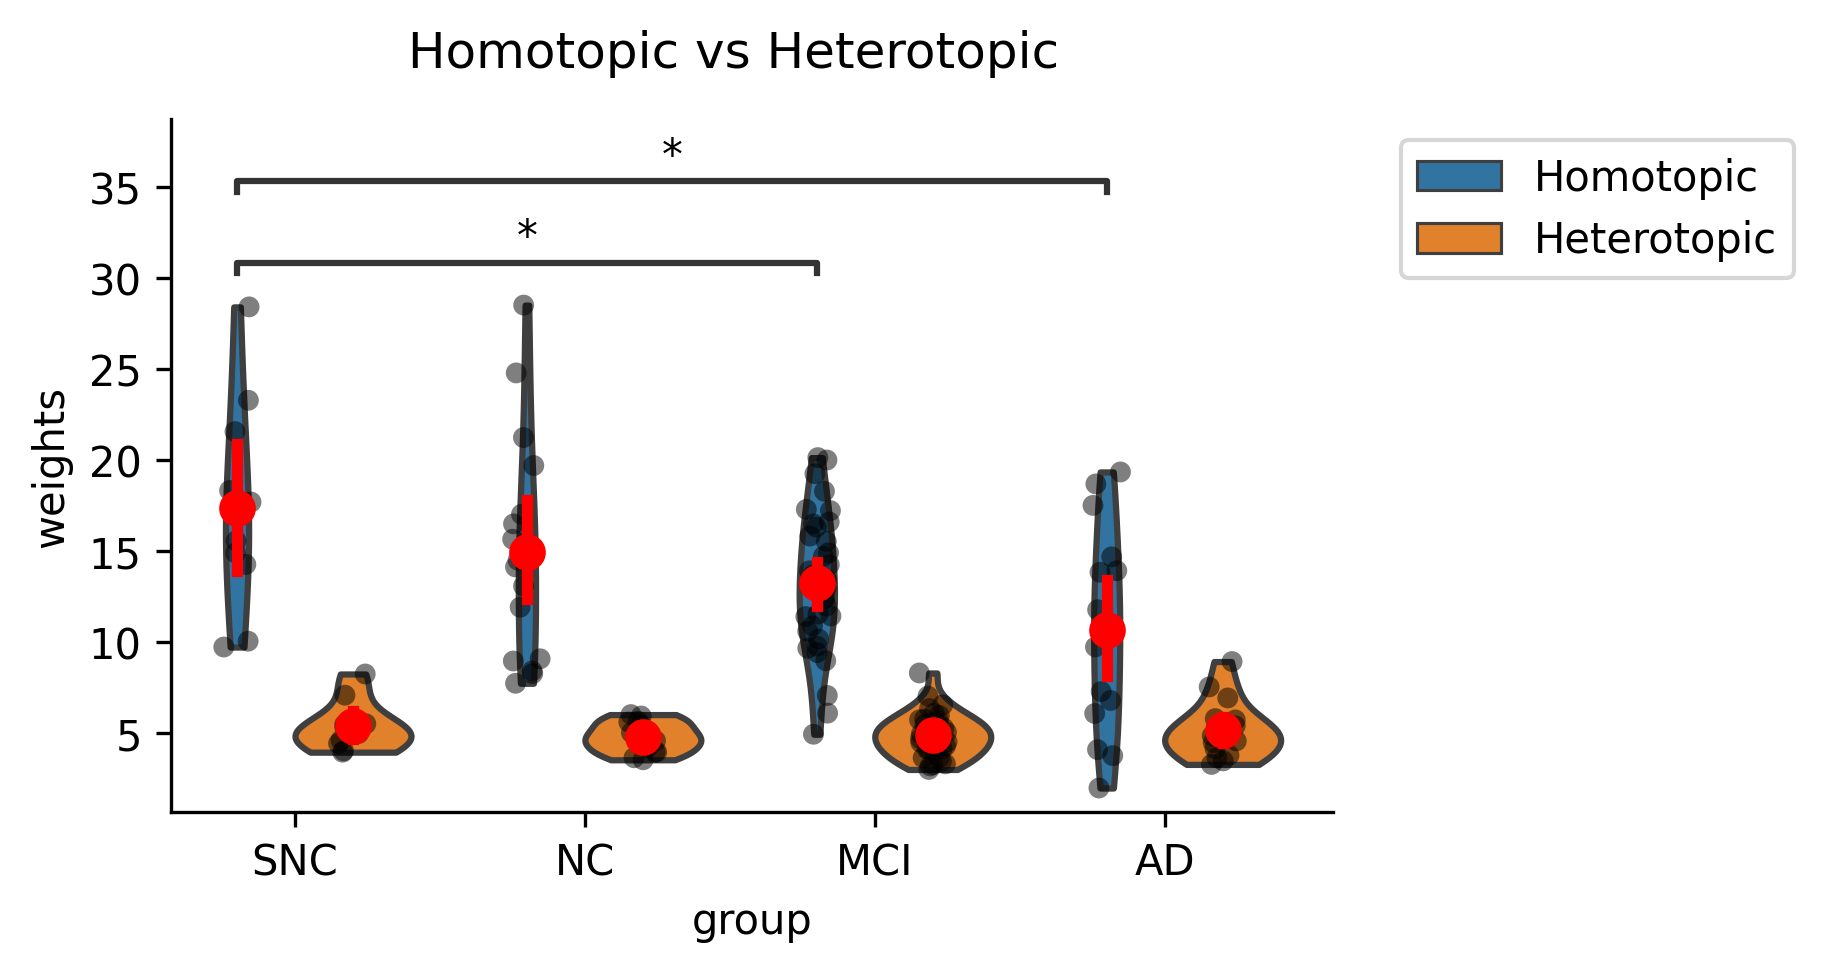

In [30]:
homo = pd.read_excel(pjoin(new_asymmetry, 'sc_homo_hetero.xlsx'),sheet_name="homo")
hetero = pd.read_excel(pjoin(new_asymmetry, 'sc_homo_hetero.xlsx'),sheet_name="hetero")

tracts = ["Homotopic"]*77 + ["Heterotopic"]*77
yr = pd.concat([homo.average_homo, hetero.average_hetero], axis=0)
gr = pd.concat([homo.group, hetero.group], axis = 0)

figure = plt.figure(figsize=(5,3), dpi=300)
ax1 = figure.add_subplot(111)
figure.suptitle("Homotopic vs Heterotopic")
sns.violinplot(x=gr, y=yr, hue=tracts, ax=ax1, inner=None,cut=0, palette=sns.color_palette('tab10'))
sns.stripplot(x=gr, y=yr, hue = tracts, dodge=0.5, palette=['black'], jitter=True,  alpha=0.5, zorder=1,ax=ax1)
sns.pointplot(x=gr, y=yr, hue = tracts, estimator=np.mean, palette=["red"], dodge=0.4, errorbar = None,ax=ax1, join=True, linestyles="", zorder=10)

# hide top and right frame
sns.despine(top=True, right=True)
ax1.set_ylabel('weights')
# only keep violinplot legend
# handles, labels = figure.gca().get_legend_handles_labels()
# plt.legend(handles[:2], labels[:2], loc='upper right')

annot = Annotator(ax1, [
            (("SNC", "Homotopic"), ("NC", "Homotopic")),(("SNC", "Homotopic"), ("MCI", "Homotopic")), (("SNC","Homotopic"), ("AD", "Homotopic")), (("NC", "Homotopic"), ("MCI", "Homotopic")),(("NC", "Homotopic"),("AD", "Homotopic")), (("MCI", "Homotopic"),("AD", "Homotopic"))],
            x=gr,
            y=yr,
            hue=tracts)
annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True)
annot.apply_and_annotate()

ax1.legend([],[], frameon=False)
handles, labels = figure.gca().get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2],bbox_to_anchor=(1.04, 1), loc="upper left")

### Section 2.2: Weighted Degree Centrality results

Index(['aCNG-L', 'aCNG-R'], dtype='object')
Index(['mCNG-L', 'mCNG-R'], dtype='object')
Index(['pCNG-L', 'pCNG-R'], dtype='object')
Index(['HIP-L', 'HIP-R'], dtype='object')
Index(['PHG-L', 'PHG-R'], dtype='object')
Index(['AMY-L', 'AMY-R'], dtype='object')
Index(['sTEMp-L', 'sTEMP-R'], dtype='object')
Index(['mTEMp-L', 'mTEMp-R'], dtype='object')
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SNC vs. AD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.313e-03 U_stat=1.550e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data p

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


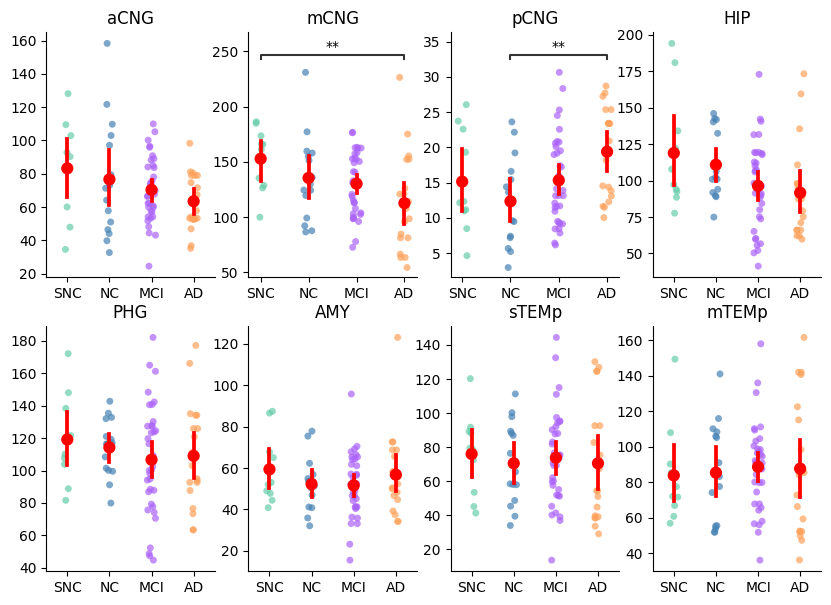

In [16]:
group = ['SNC', 'NC', 'MCI', 'AD']
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]

df = pd.read_csv(pjoin(new_asymmetry, "assymetry_wdc.csv"))

for ind in range(0,16,2):
    # mc_individual[f"{key[:-2]}_diff"] = np.abs(mc_individual.iloc[:,ind+2] - mc_individual.iloc[:,ind+3]) / (mc_individual.iloc[:,ind+2] + mc_individual.iloc[:,ind+3])
    print(df.columns[ind+2:ind+4])
    df[f"{df.columns[ind+2][:-2]}_avg"] = np.mean(df.iloc[:,ind+2:ind+4], axis=1)


figure = plt.figure(figsize=(10,7))
for ind, key in enumerate(df.columns[18:]):
    ax = figure.add_subplot(2,4,ind+1)
    ax.set_title(key[:-4])
    # sns.violinplot(x="group", y="average", data=mc_individual, cut=0)
    sns.stripplot(x="group", y=key,data=df, palette=colors, label=None, alpha=0.7, ax=ax, zorder=0)
    sns.pointplot(x="group", y=key,data=df, markers="o", color="red", errorbar=None, linestyles="None",ax=ax, zorder=10)
    annot = Annotator(ax, [
                (("SNC"), ("NC")),(("SNC"), ("MCI")), (("SNC"), ("AD")), (("NC"), ("MCI")),(("NC"),("AD")), (("MCI"),("AD"))],
                x="group",
                y=key,
                data = df)
    annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True, comparisons_correction='BH')
    annot.apply_and_annotate()
    sns.despine(top=True, right=True)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.show()

<Axes: xlabel='group', ylabel='average_hetero'>

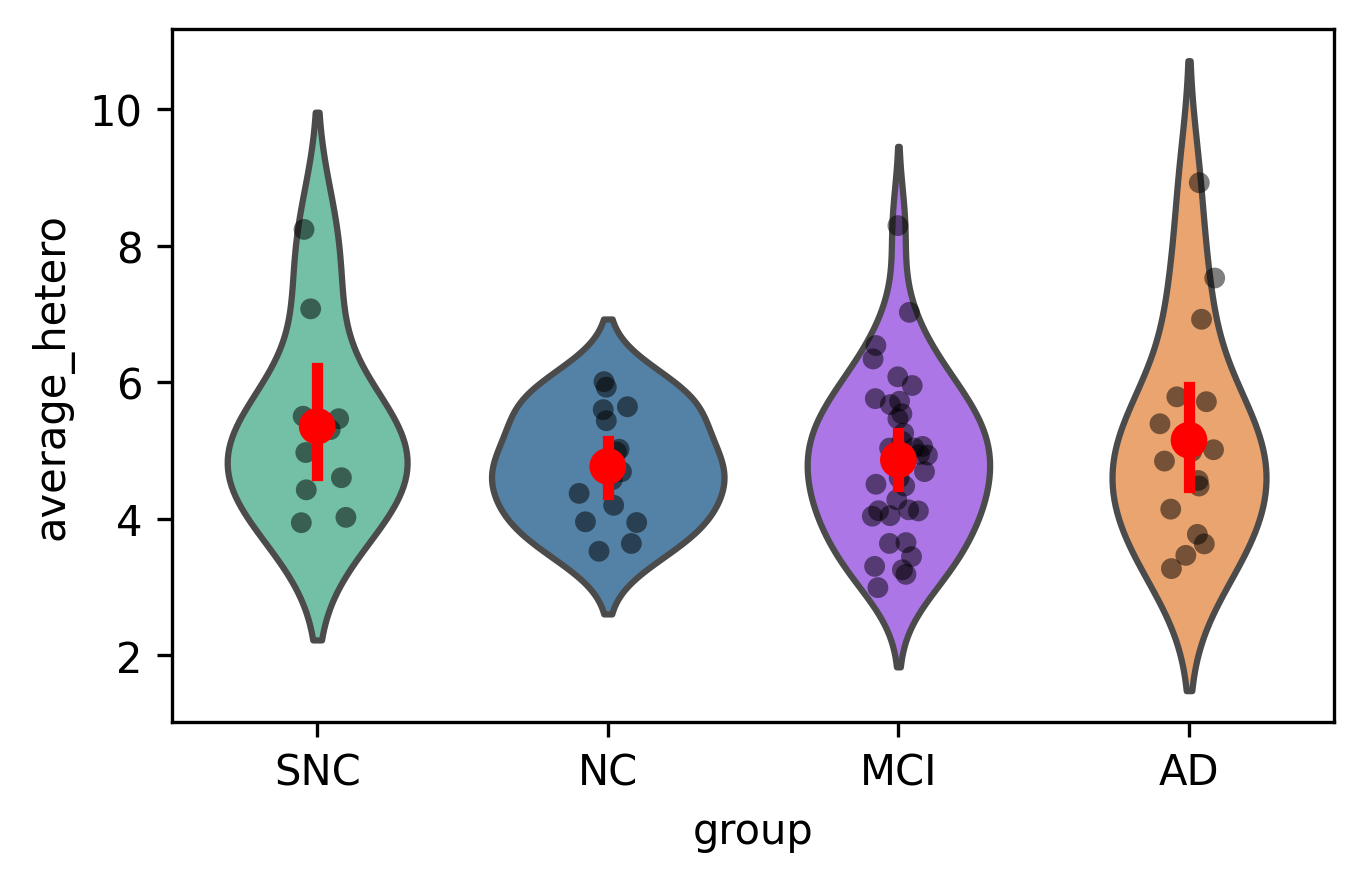

In [17]:
homo = pd.read_excel('/Users/yilewang/workspaces/data4project/new_asymmetry/sc_homo_hetero.xlsx',sheet_name="homo")
hetero = pd.read_excel('/Users/yilewang/workspaces/data4project/new_asymmetry/sc_homo_hetero.xlsx',sheet_name="hetero")
# plot the distribution
figure = plt.figure(figsize=(5, 3),dpi=300)

ax1 = figure.add_subplot(111)

data= hetero
x='group'
y='average_hetero'

sns.violinplot(x='group', y=y, data=data,  ax=ax1, inner=None,zorder=0, palette=colors)
sns.stripplot(x='group', y = y, data= data, dodge=0.5, palette=['black'], ax=ax1, jitter=True,  alpha=0.5, zorder=1)
sns.pointplot(x = 'group' , y=y, data=data, estimator=np.mean, palette=['red'],ax=ax1, dodge=0.4, errorbar = None, join=True, linestyles="", zorder=10)



In [18]:

# for loop to read data

new_homo = pd.DataFrame(columns=["group", "caseid", *node_one])
for caseid, group in zip(hetero.caseid, hetero.group):
    # Load the data
    datapath = '/Users/yilewang/workspaces/data4project/lateralization/connectome/unzip/' + group + '/' + caseid + '/weights.txt'
    scl = open(datapath,"r")
    lines = scl.read()
    tmp_d = pd.read_csv(io.StringIO(lines), sep='\t', header=None, index_col=None, engine="python")
    tmp_df = tmp_d.set_axis(node_names, axis=0) # set the index
    df_sc = tmp_df.set_axis(node_names, axis=1) # set the columns
    single_homo = pd.DataFrame()
    connect = np.array([])
    for index in range(8):
        # homotopic
        tmp_connect = df_sc.iloc[2*index+1, 2*index]
        connect = np.append(connect, tmp_connect)
    single_homo["group"] = [group]
    single_homo["caseid"] = [caseid]
    single_homo[node_one] = [connect]
    new_homo = pd.concat([new_homo, single_homo], ignore_index=True)
# new_homo.to_csv('/Users/yilewang/workspaces/data4project/sc_new_homo.csv')
    
    

### Section 3: Meta-connectivity

### MC homotopic connectivity, group level

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. MCI: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.702e-06 U_stat=3.000e+00
MCI vs. SNC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.849e-02 U_stat=6.500e+01
AD vs. NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.545e-06 U_stat=0.000e+00
AD vs. SNC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.545e-06 U_stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. MCI: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.490e-03 U_stat=5.000e+01
AD vs. NC: Mann-Whitney-Wi

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


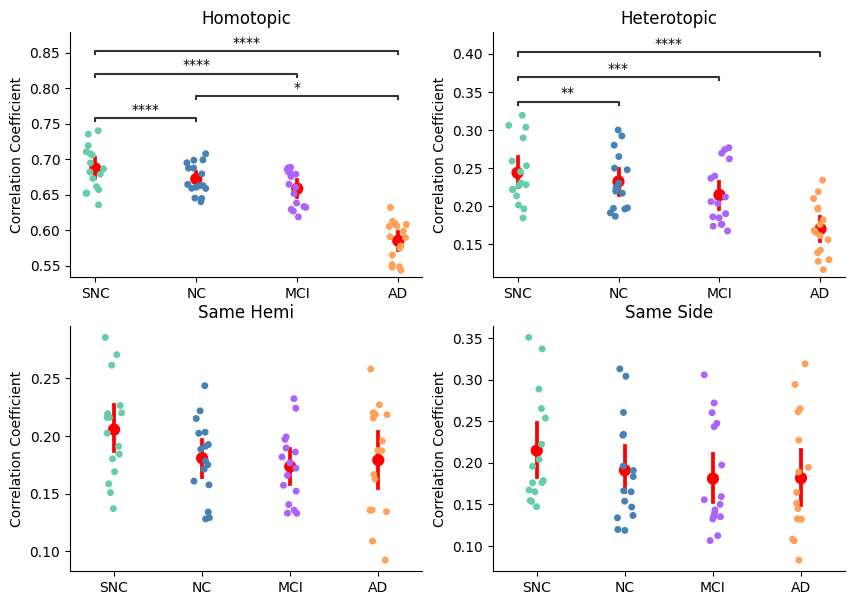

In [19]:
### Group level comparison

mc_group_homo = pd.read_excel(pjoin(new_asymmetry, 'meta', "mc_group_homo.xlsx"))
mc_group_hetero = pd.read_excel(pjoin(new_asymmetry, 'meta',"mc_group_hetero.xlsx"))
mc_group_same_hemi = pd.read_excel(pjoin(new_asymmetry, 'meta',"mc_group_same_hemi.xlsx"))
mc_group_same_side = pd.read_excel(pjoin(new_asymmetry, 'meta',"mc_group_same_side.xlsx"))


def vplot(x,y,data,ax, title=None, order=["SNC","NC","MCI","AD"]):
    sns.stripplot(x=x,y=y,data=data, order=order, palette=colors, ax=ax)
    sns.pointplot(x=x,y=y,data=data, color='red', linestyles="", order=order, ax=ax)
    ax.set_title(title)
    annot = Annotator(ax, [
                    (("SNC"), ("NC")),(("SNC"), ("MCI")), (("SNC"), ("AD")), (("NC"), ("MCI")),(("NC"),("AD")), (("MCI"),("AD"))],
                    x=x,
                    y=y,
                    data = data)
    annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True, comparisons_correction='BH')
    annot.apply_and_annotate()
    sns.despine(top=True, right=True)
    ax.set_ylabel('Correlation Coefficient')
    ax.set_xlabel('')


figure = plt.figure(figsize=(10,7))
ax1= figure.add_subplot(221)
vplot('group','values',mc_group_homo,ax1, title='Homotopic')
ax2 = figure.add_subplot(222)
vplot('group','values',mc_group_hetero,ax2, title='Heterotopic')
ax3= figure.add_subplot(223)
vplot('group','values',mc_group_same_hemi,ax3, title='Same Hemi')
ax4 = figure.add_subplot(224)
vplot('group','values',mc_group_same_side,ax4, title='Same Side')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MCI vs. AD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.917e-05 U_stat=1.880e+02
NC vs. AD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.252e-06 U_stat=1.950e+02
SNC vs. AD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.468e-06 U_stat=1.960e+02


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


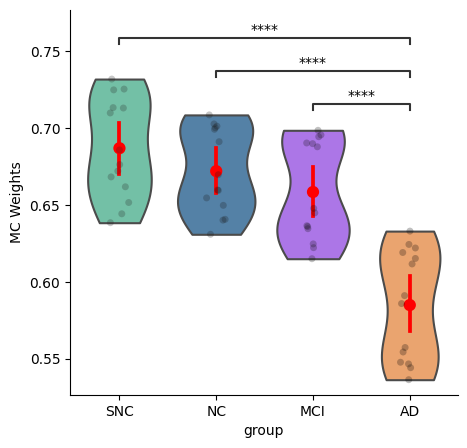

In [20]:
# group level MC homo
mc_homo = pd.read_excel("/Users/yilewang/workspaces/data4project/lateralization/gc1sec_res/meta/mc_homo.xlsx")
mc_homo['avg'] = mc_homo.iloc[:, 2:].mean(axis=1)

colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
figure = plt.figure(figsize=(5,5))
sns.violinplot(x="group", y = "avg", data=mc_homo, inner=None, palette=colors, cut=0)
sns.stripplot(x="group", y = "avg", data=mc_homo, palette='dark:black', label=None, alpha=0.25)
sns.pointplot(x="group", y = "avg", data=mc_homo, markers="o", color="red", errorbar=None, linestyles="None")


annot = Annotator(figure.gca(), [
            (("SNC"), ("NC")),(("SNC"), ("MCI")), (("SNC"), ("AD")), (("NC"), ("MCI")),(("NC"),("AD")), (("MCI"),("AD"))],
            x="group",
            y='avg',
            data = mc_homo)
annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True, comparisons_correction = "BH")
annot.apply_and_annotate()
plt.ylabel("MC Weights")
sns.despine(top=True, right=True)


### Individual trimer

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MCI vs. AD: Mann-Whitney-Wilcoxon test two-sided, P_val:3.281e-02 U_stat=3.200e+02
NC vs. AD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.143e-02 U_stat=1.510e+02
SNC vs. AD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.430e-02 U_stat=1.050e+02


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC vs. AD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.132e-02 U_stat=1.570e+02
SNC vs. AD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.385e-02 U_stat=9.800e+01


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SNC vs. NC: Mann-Whitney-Wilcoxon test two-sided, P_val:4.245e-02 U_stat=1.190e+02
SNC vs. MCI: Mann-Whitney-Wilcoxon test two-sided, P_val:9.882e-03 U_stat=2.700e+02
SNC vs. AD: Mann-Whitney-Wilcoxon test two-sided, P_val:3.775e-02 U_stat=9.900e+01


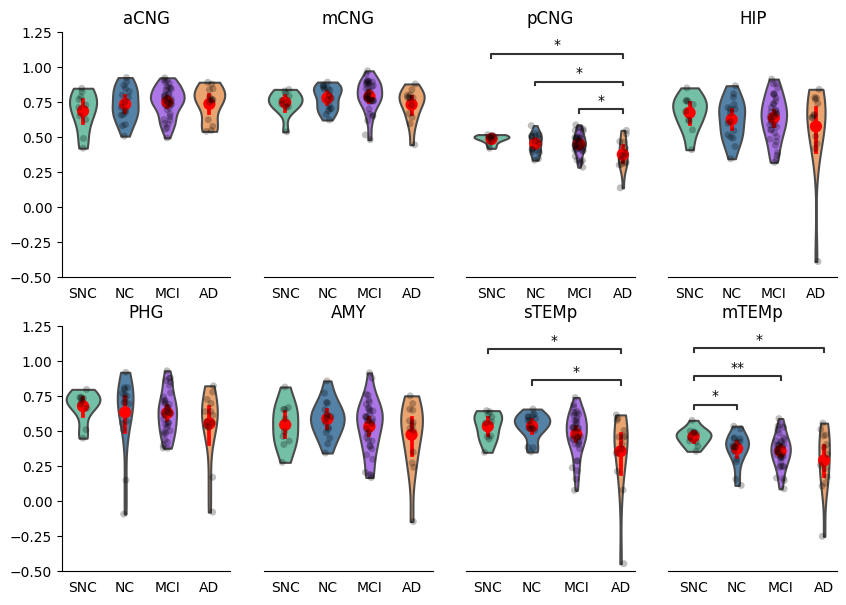

In [21]:
# individual trimer
mc_individual = pd.read_excel(pjoin(new_asymmetry, 'meta',"individualized_homo.xlsx"))

mc_individual['average'] = mc_individual.iloc[:, 2:].mean(axis=1)
mc_individual['zone1_average'] = mc_individual.iloc[:,2:5].mean(axis=1)
mc_individual['zone2_average'] = mc_individual.iloc[:,5:].mean(axis=1)

figure, axes = plt.subplots(2, 4, figsize=(10,7))
for ind, key in enumerate(node_one):
    axes.flat[ind].set_title(key)
    sns.violinplot(x="group", y=key, data=mc_individual, palette=colors, inner=None, cut=0, zorder = 0, ax= axes.flat[ind])
    sns.stripplot(x="group", y=key,data=mc_individual, color='black', label=None, alpha=0.25, zorder=5, ax= axes.flat[ind])
    sns.pointplot(x="group", y=key,data=mc_individual, markers="o", color="red", errorbar=None, linestyles="None", zorder=10, ax= axes.flat[ind])
    axes.flat[ind].set_ylim(-0.5, 1.25)
    annot = Annotator(axes.flat[ind], [
                (("SNC"), ("NC")),(("NC"), ("MCI")), (("MCI"), ("AD")), (("SNC"), ("MCI")),(("NC"),("AD")), (("SNC"),("AD"))],
                x="group",
                y=key,
                data = mc_individual)
    annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True)
    annot.apply_and_annotate()
    sns.despine(top=True, right=True)
    axes.flat[ind].set_xlabel('')
    axes.flat[ind].set_ylabel('')
    axes.flat[ind].xaxis.set_ticks_position('none') 

# Hide yticklabels for axes 0, 2, 3, 4, 6, and 7
for i, ax in enumerate(axes.flat):
    if i not in [0, 4]:
        ax.set_yticks([])
        sns.despine(ax=ax, left=True)
plt.show()